<a href="https://colab.research.google.com/github/ritwiks9635/My_priject_file_4/blob/main/SMS_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UNZIP THE DATASET

In [ ]:
from zipfile import ZipFile
data = "/content/https:/www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/sms-spam-collection-dataset.zip"
with ZipFile(data,"r") as zip:
  zip.extractall()
  print("the data has been extracted ")

the data has been extracted 


In [ ]:
#Scammers create fraudulent text messages to deceive
# you into giving them your personal information,
# such as your password, account number, or Social
# Security number. If they have such information,
# they may be able to gain access to your email, bank, or other accounts.
# we will develop spam detection to check email spam or not

In [ ]:
# Dataset == https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

IMPORT MODULE

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

Load the dataset using pandas

In [ ]:
dataset = pd.read_csv("/content/spam.csv", encoding ="latin-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# as we see this has three unnamed columns with null values.
# so drop this columns
# rename v1 and v2 to label and emails
# convert ham :: 0, spam :: 1

In [ ]:
df = dataset.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'SMS'})
df['labels'] = df['label'].map({'ham':0,'spam':1})
df.head()

In [ ]:
df.shape

(5572, 3)

In [ ]:
df["labels"].value_counts()

0    4825
1     747
Name: labels, dtype: int64

In [ ]:
# Visualize label columns

<Axes: xlabel='label', ylabel='count'>

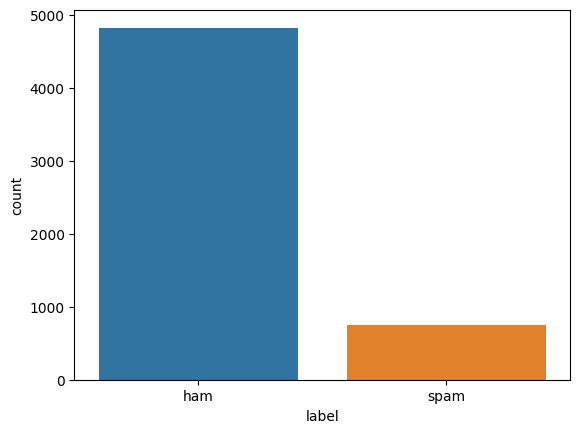

In [ ]:
sns.countplot(x = df["label"])

Data Preparation for Training

In [ ]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['SMS']])/len(df['SMS']))
print(avg_words_len)

15


In [ ]:
# Finding Total numbers of unique words in corpus
s = set()
for sent in df['SMS']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [ ]:
# Spplit the datasets

In [ ]:
X, y = np.asanyarray(df['SMS']), np.asanyarray(df['labels'])
new_df = pd.DataFrame({'SMSs': X, 'label': y})

In [ ]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(new_df["SMSs"], new_df["label"], test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [ ]:
# First, we will build a baseline model and
# then we’ll try to beat the performance of
# the baseline model using deep learning models (embeddings, LSTM, etc)

In [ ]:
# we will choose MultinomialNB(), which performs well for text classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
#The tf-idf is a measure that tells how important or relevant a word is the document.
tfidf_vec = TfidfVectorizer().fit(x_train)
x_train_vec,x_test_vec = tfidf_vec.transform(x_train),tfidf_vec.transform(x_test)
 
baseline_model = MultinomialNB()
baseline_model.fit(x_train_vec,y_train)

MultinomialNB()

In [ ]:
# check baseline model performance

In [ ]:
accuracy = accuracy_score(y_test, baseline_model.predict(x_test_vec))
print(accuracy)
print(classification_report(y_test, baseline_model.predict(x_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



Model_1 :: Creating custom Text vectorization and embedding layers

In [ ]:
# Text vectorization is the process of converting text into a numerical representation.
# A word embedding is a learned representation of text in which words with related meanings have similar representations.

In [ ]:
from tensorflow.keras.layers import TextVectorization
# max_token is the maximum size of the vocabulary
max_token = total_words_length
# output_len which the sentences should be padded irrespective of the sentence length.
output_len = avg_words_len
 
text_vec = TextVectorization(
    max_tokens = max_token,
    standardize = 'lower_and_strip_punctuation',
    output_mode = 'int',
    output_sequence_length = output_len
)
text_vec.adapt(x_train)

In [ ]:
# test the text_vec

In [ ]:
sample = "it's my project"
text_vec([sample])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 43,  12, 676,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
embedding_layer = layers.Embedding(
    input_dim=max_token,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=output_len 
)

In [ ]:

input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)
 
model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5), metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [ ]:
history_1 = model_1.fit(x_train, y_train,
            validation_data = (x_test, y_test),
            epochs = 5,
            validation_steps = int(0.2*len(x_test)))

Epoch 1/5
140/140 [==============================] - 18s 89ms/step - loss: 0.6053 - accuracy: 0.9114 - val_loss: 0.5775 - val_accuracy: 0.9704
Epoch 2/5
140/140 [==============================] - 3s 23ms/step - loss: 0.5702 - accuracy: 0.9868 - val_loss: 0.5733 - val_accuracy: 0.9821
Epoch 3/5
140/140 [==============================] - 3s 22ms/step - loss: 0.5658 - accuracy: 0.9953 - val_loss: 0.5729 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 2s 13ms/step - loss: 0.5642 - accuracy: 0.9982 - val_loss: 0.5730 - val_accuracy: 0.9794
Epoch 5/5
140/140 [==============================] - 2s 13ms/step - loss: 0.5635 - accuracy: 0.9991 - val_loss: 0.5732 - val_accuracy: 0.9794


<Axes: >

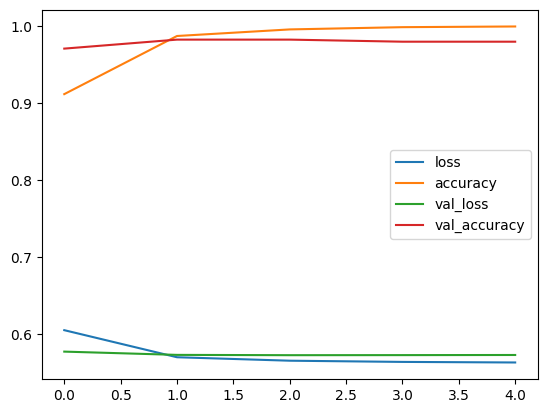

In [ ]:
pd.DataFrame(history_1.history).plot()

In [ ]:
# create helper functions for compiling, fitting, and evaluating the model performance

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
 
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
 
def fit_model(model, epochs, X_train=x_train, y_train=y_train,
              X_test=x_test, y_test=y_test):
    '''
    fit the model with given epochs, train
    and test data
    '''
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history
 
def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
 
    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}
 
    return model_results_dict

Model_2 :: Bidirectional LSTM

In [ ]:
# A bidirectional LSTM (Long short-term memory)
# is made up of two LSTMs, one accepting input in
# one direction and the other in the other.

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
    64,activation="tenh", return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)
 
compile_model(model_2)  # compile the model
history_2 = fit_model(model_2, epochs=5)  # fit the model

Model_3 Transfer Learning with USE Encoder

In [ ]:
#Transfer learning is a machine learning 
#approach in which a model generated 
#for one job is utilized as the foundation
# for a model on a different task.

In [ ]:
# The Universal Sentence Encoder converts
# text into high-dimensional vectors that
# may be used for text categorization,
# semantic similarity, and other natural
# language applications.

In [ ]:

import tensorflow_hub as hub
 
# model with Sequential api
model_3 = keras.Sequential()
 
# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))
 
compile_model(model_3)
 
history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 8s 32ms/step - loss: 0.2970 - accuracy: 0.9150 - val_loss: 0.1138 - val_accuracy: 0.9713
Epoch 2/5
140/140 [==============================] - 4s 26ms/step - loss: 0.0808 - accuracy: 0.9778 - val_loss: 0.0703 - val_accuracy: 0.9785
Epoch 3/5
140/140 [==============================] - 4s 31ms/step - loss: 0.0571 - accuracy: 0.9843 - val_loss: 0.0598 - val_accuracy: 0.9794
Epoch 4/5
140/140 [==============================] - 3s 22ms/step - loss: 0.0490 - accuracy: 0.9838 - val_loss: 0.0530 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 4s 29ms/step - loss: 0.0398 - accuracy: 0.9877 - val_loss: 0.0519 - val_accuracy: 0.9821


Analyzing our Model Performance

In [ ]:

baseline_model_results = evaluate_model(baseline_model, x_test_vec, y_test)
model_1_results = evaluate_model(model_1, x_test, y_test)
model_2_results = evaluate_model(model_2, x_test, y_test)
model_3_results = evaluate_model(model_3, x_test, y_test)
 
total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()
 
total_results

35/35 [==============================] - 1s 16ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.979372,0.963504,0.880000,0.919861
USE-Transfer learning Model,0.982063,0.957746,0.906667,0.931507
